# ELAIS-S1 master catalogue
## Preparation of ESO-Spitzer Imaging extragalactic Survey (ESIS) / 2.2-m MPG/ESO telescope at La Silla

The catalogue comes from `dmu0_ESIS-VOICE`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band in aperture 4 (2").
- The total (auto) magnitude.

We don't know when the maps have been observed. We will use the year of the reference paper.

In [9]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
ae28a36 (Mon Jul 10 16:31:54 2017 +0100)


In [10]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [11]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "voice_ra"
DEC_COL = "voice_dec"

## I - Column selection

In [15]:
#Aperture 6 is 3 arcsec, Aperture 4 is 2 arcsec. We are now using 2 arcsec!
#There appear to be four bands in the catalogue B99/B123/V89/R162 (1/2/3/4)
#Multiple class star - for each band
imported_columns = OrderedDict({
    'ID':'voice_id', 
    'ALPHA_J2000':'voice_ra', 
    'DELTA_J2000':'voice_dec', 
    'CLASS_STAR_2':'voice_stellarity',     
    'MAG_APER_4_1':'m_ap_voice_b99', 
    'MAGERR_APER_4_1':'merr_ap_voice_b99', 
    'MAG_AUTO_1':'m_voice_b99', 
    'MAGERR_AUTO_1':'merr_voice_b99',
    'MAG_APER_4_2':'m_ap_voice_b123', 
    'MAGERR_APER_4_2':'merr_ap_voice_b123', 
    'MAG_AUTO_2':'m_voice_b123', 
    'MAGERR_AUTO_2':'merr_voice_b123',
    'MAG_APER_4_3':'m_ap_voice_v', 
    'MAGERR_APER_4_3':'merr_ap_voice_v', 
    'MAG_AUTO_3':'m_voice_v', 
    'MAGERR_AUTO_3':'merr_voice_v',
    'MAG_APER_4_4':'m_ap_voice_r', 
    'MAGERR_APER_4_4':'merr_ap_voice_r', 
    'MAG_AUTO_4':'m_voice_r', 
    'MAGERR_AUTO_4':'merr_voice_r'
    })


catalogue = Table.read("../../dmu0/dmu0_ESIS-VOICE/data/esis_b2vr_cat_03_HELP-coverage.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2016

# Clean table metadata
catalogue.meta = None

In [16]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        errcol = "merr{}".format(col[1:])
        
        # voice uses 99. for missing values
        catalogue[col][catalogue[col] == 99.] = np.nan
        catalogue[errcol][catalogue[errcol] == 99.] = np.nan
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))

        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.        
   

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [17]:
catalogue[:10].show_in_notebook()

idx,voice_id,voice_ra,voice_dec,voice_stellarity,m_ap_voice_b99,merr_ap_voice_b99,m_voice_b99,merr_voice_b99,m_ap_voice_b123,merr_ap_voice_b123,m_voice_b123,merr_voice_b123,m_ap_voice_v,merr_ap_voice_v,m_voice_v,merr_voice_v,m_ap_voice_r,merr_ap_voice_r,m_voice_r,merr_voice_r,f_ap_voice_b99,ferr_ap_voice_b99,flag_ap_voice_b99,f_voice_b99,ferr_voice_b99,flag_voice_b99,f_ap_voice_b123,ferr_ap_voice_b123,flag_ap_voice_b123,f_voice_b123,ferr_voice_b123,flag_voice_b123,f_ap_voice_v,ferr_ap_voice_v,flag_ap_voice_v,f_voice_v,ferr_voice_v,flag_voice_v,f_ap_voice_r,ferr_ap_voice_r,flag_ap_voice_r,f_voice_r,ferr_voice_r,flag_voice_r
,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,
0,1,9.17825712092,-43.955836523,0.986996,13.9236,8.4457e-05,12.7221,5.16706e-05,14.2503,0.000101843,12.8877,5.22983e-05,13.5755,8.20345e-05,12.2352,4.02783e-05,13.984,6.49709e-05,12.2731,4.22112e-05,9785.04,0.761156,False,29592.0,1.40829,False,7242.41,0.679344,False,25405.1,1.22372,False,13483.3,1.01875,False,46337.8,1.71902,False,9255.35,0.553844,False,44747.6,1.7397,False
1,2,9.47919711452,-43.9648762673,0.982173,14.2107,8.45055e-05,12.0554,3.64481e-05,14.1475,6.7729e-05,11.7522,2.88469e-05,13.7885,7.7651e-05,11.1475,3.09307e-05,nan,nan,nan,nan,7511.25,0.584619,False,54682.7,1.83569,False,7961.83,0.496665,False,72297.2,1.92086,False,11081.2,0.792515,False,126179.0,3.5946,False,nan,nan,False,nan,nan,False
2,3,9.38616907676,-43.9722384073,0.999861,14.3789,9.70481e-05,14.0156,7.99634e-05,14.5345,7.23813e-05,14.0903,5.68381e-05,13.9867,8.53511e-05,13.6356,7.10772e-05,14.187,5.41758e-05,13.4066,3.9822e-05,6433.64,0.575068,False,8990.02,0.662107,False,5574.17,0.371606,False,8392.67,0.439354,False,9232.82,0.725804,False,12757.7,0.835178,False,7677.38,0.383084,False,15752.8,0.577771,False
3,4,9.85183392833,-43.9831608454,0.997188,13.9961,0.000164294,13.2806,0.000119572,14.3682,7.3718e-05,13.5524,4.90276e-05,13.6165,0.000110415,12.8226,9.92741e-05,14.0959,7.29783e-05,12.5802,5.177e-05,9152.72,1.38499,False,17691.8,1.9484,False,6497.25,0.441142,False,13773.4,0.621953,False,12983.4,1.32035,False,26975.1,2.46646,False,8348.98,0.561181,False,33722.3,1.60795,False
4,5,8.82068013986,-43.9885337429,0.970392,13.9923,0.00043213,11.3499,0.000112695,14.1074,8.69714e-05,11.1735,2.61241e-05,13.5545,0.000114785,10.8482,3.71954e-05,13.9477,0.000102743,11.0449,3.27186e-05,9185.18,3.65577,False,104721.0,10.8696,False,8260.78,0.661719,False,123203.0,2.96439,False,13746.7,1.45332,False,166233.0,5.69484,False,9569.88,0.9056,False,138687.0,4.17933,False
5,6,8.79679406122,-43.9850531388,0.0286267,18.492,0.00144791,15.058,0.000852961,18.7189,0.000906894,14.8657,0.000381861,18.0462,0.00098831,14.2728,0.000451806,16.9328,0.000413796,13.2539,0.000339681,145.617,0.194191,False,3441.8,2.70389,False,118.149,0.0986878,False,4108.71,1.44506,False,219.543,0.199843,False,7093.89,2.95197,False,612.207,0.233324,False,18131.4,5.67256,False
6,7,8.80327818802,-43.9855703407,nan,20.1642,0.00408593,19.7822,0.00610169,nan,nan,nan,nan,nan,nan,nan,nan,17.9358,0.000683203,17.7011,0.000869065,31.2123,0.11746,False,44.3738,0.249375,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,243.05,0.15294,False,301.698,0.241491,False
7,8,9.84925878674,-43.9855297377,0.960899,13.92,0.000158234,12.4718,8.48421e-05,14.3458,7.86197e-05,12.639,3.92947e-05,13.5297,0.000112788,12.0793,6.75566e-05,14.0968,7.33729e-05,11.8414,3.80297e-05,9817.14,1.43074,False,37263.7,2.91188,False,6632.64,0.480279,False,31946.1,1.15618,False,14064.9,1.46107,False,53491.7,3.32836,False,8341.82,0.563731,False,66593.0,2.33253,False
8,9,9.91952030686,-43.9863998576,nan,21.3405,0.0111676,16.9629,0.00351602,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,10.5634,0.108653,False,595.445,1.92827,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [18]:
SORT_COLS = ['merr_ap_voice_b99', 'merr_ap_voice_b123', 'merr_ap_voice_v', 'merr_ap_voice_r']
FLAG_NAME = 'voice_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 100635 sources.
The cleaned catalogue has 99904 sources (731 removed).
The cleaned catalogue has 591 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [19]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_ELAIS-S1.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

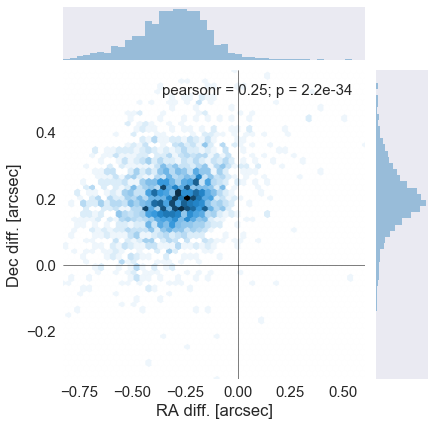

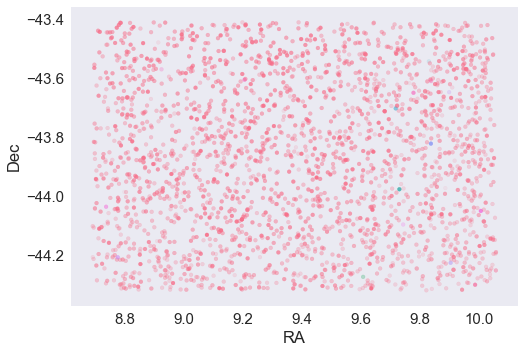

In [20]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [21]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.29934475093256196 arcsec
Dec correction: -0.19818944373639624 arcsec


In [22]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

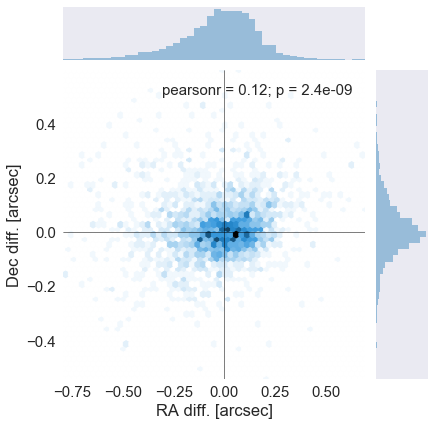

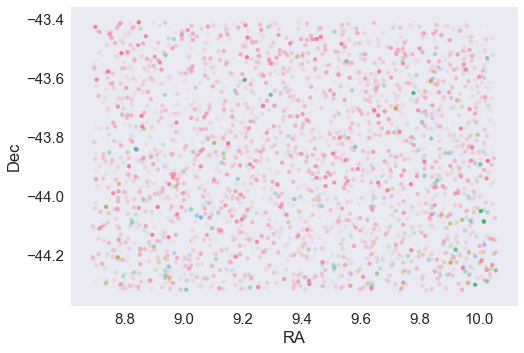

In [23]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [24]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [25]:
GAIA_FLAG_NAME = "voice_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

2487 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [26]:
catalogue.write("{}/ESIS-VOICE.fits".format(OUT_DIR), overwrite=True)